In [423]:
import numpy as np
import osr_methods as osr
import line_search_methods as lsm
import ocr_methods as ocr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from timeit import default_timer as timer

### Definição do Ponto Inicial

In [424]:
#exterior
#x = np.array([3., 2.])

#interior
x = np.array([0., 1.])

### Escolha dos métodos de OSR e OCR

In [425]:
# Metodos OCR
# 1 - Penalidade
# 2 - Barreira
metodo_ocr = 2

if (metodo_ocr == 1):
    n_met_ocr = "Penalidade"
elif (metodo_ocr == 2):
    n_met_ocr = "Barreira"

# Metodos OSR
# 1 - Univariante
# 2 - Powell
# 3 - Stepest Descent
# 4 - Newton-Raphson
# 5 - Fletcher-Reeves
# 6 - BFGS
metodo_osr = 4

if (metodo_osr == 1):
    n_met = 'Univariante'
elif (metodo_osr == 2):
    n_met = 'Powell'
elif (metodo_osr == 3):
    n_met = 'Steepest Descent'
elif (metodo_osr == 4):
    n_met = 'Newton-Raphson'
elif (metodo_osr == 5):
    n_met = 'Fletcher-Reeves'
elif (metodo_osr == 6):
    n_met = 'BFGS'

### Controle Numérico

In [426]:
# numero maximo de iteracoes na OSR
maxiter = 1000000

# tolerancia para convergencia do gradiente na OSR
tol_conv = 1E-4

# tolerancia para a busca unidirecional na OSR
tol_search = 1E-12

# delta alpha do passo constante na OSR
line_step = 1E-4

#epsilon da maquina
eps = 1E-10

#parametros ocr
if metodo_ocr == 1:
    #penalidade
    r = 1
    beta = 10
elif metodo_ocr == 2:
    #barreira
    r = 10
    beta = 0.1

#tolerancia OCR
tol = 1E-3

ctrl_num_osr = [maxiter, tol_conv, tol_search, line_step, eps]

### Definição de f

In [427]:
def f(x):
    return (x[0]-2)**4 + (x[0] - 2*x[1])**2

def grad_f(x):
    return np.array([4*(x[0]-2)**3 + 2*(x[0] - 2*x[1]), 2*(x[0] - 2*x[1])*(-2)])

def hess_f(x):
    hess = np.zeros((2,2), dtype=float)
    hess[0,:] = np.array([12*(x[0]-2)**2 + 2, -4.])
    hess[1,:] = np.array([-4., 8.])
    return hess

### Definição das restrições de desigualdade

In [428]:
def cl1(x):
    return x[0]**2 - x[1]

def grad_cl1(x):
    return np.array([2*x[0], -1.])

def hess_cl1(x):
    hess = np.zeros((2,2), dtype=float)
    hess[0,:] = np.array([2., 0.])
    hess[1,:] = np.array([0., 0])
    return hess

### Listas de Restrições e suas derivadas

In [429]:
hk_list = []
grad_hk_list = []
hess_hk_list = []

cl_list = [cl1]
grad_cl_list = [grad_cl1]
hess_cl_list = [hess_cl1]

#para o metodo de penalidade
#controle de quais cls irao montar a phi
cl_mont = []
if metodo_ocr == 1:
    for cl in cl_list:
        if cl(x) > 0:
            cl_mont.append(1)
        else:
            cl_mont.append(0)
            
params = [f, grad_f, hess_f, hk_list, grad_hk_list, hess_hk_list, cl_list, grad_cl_list, hess_cl_list, cl_mont]


### Otimização

In [430]:

if metodo_ocr == 1:
    parc = (1/2)*r*ocr.p_penal(x, params)
elif metodo_ocr == 2:
    parc = r*ocr.b_bar(x, params)
    
listP_OCR = []
listP_OCR.append(x)

listResultsOSR = []

passos_OCR = 0
redo = 0
print(n_met)
while(parc > tol):
    passos_OCR = passos_OCR + 1
    if passos_OCR > 1:
        r = beta*r
        if metodo_ocr == 1:
            params[-1] = []
            for cl in cl_list:
                if cl(x) > 0:
                    params[-1].append(1)
                else:
                    params[-1].append(0)
    listP_OSR, passos_OSR, conv_OSR, flag_conv_OSR, tempoExec_OSR = osr.osr_ctrl(x, params, r, ctrl_num_osr, metodo_ocr, metodo_osr)
    
    if metodo_ocr == 2:
        redo = 0
        for cl in cl_list:
            if cl(listP_OSR[-1]) > 0:
                redo = 1
                break
    if (redo == 0):
        ctrl_num_osr[3] = line_step
        x = listP_OSR[-1]
        listP_OCR.append(x)
        listResultsOSR.append([listP_OSR, params, r, metodo_ocr, metodo_osr])
        if metodo_ocr == 1:
            parc = (1/2)*r*ocr.p_penal(x, params)
        elif metodo_ocr == 2:
            parc = r*ocr.b_bar(x, params)
        print(f'{passos_OCR}: x={x}, r={r:.4e}, passos={passos_OSR}, conv_OCR={parc:.4e}, conv_OSR={conv_OSR:.4e}')
    elif (redo == 1):
        print(f'Refazendo passo {passos_OCR} com delta alpha = {0.1*ctrl_num_osr[3]}')
        passos_OCR = passos_OCR - 1
        r = r/beta
        ctrl_num_osr[3] = 0.1*ctrl_num_osr[3]    

Newton-Raphson
1: x=[0.70794439 1.53149919], r=1.0000e+01, passos=4, conv_OCR=9.7058e+00, conv_OSR=8.4881e-08
2: x=[0.82820099 1.10979856], r=1.0000e+00, passos=3, conv_OCR=2.3591e+00, conv_OSR=2.3804e-06
3: x=[0.89886446 0.96384104], r=1.0000e-01, passos=3, conv_OCR=6.4150e-01, conv_OSR=7.7636e-07
4: x=[0.92935323 0.91630684], r=1.0000e-02, passos=3, conv_OCR=1.9008e-01, conv_OSR=4.0163e-07
5: x=[0.94027829 0.90115306], r=1.0000e-03, passos=3, conv_OCR=5.8721e-02, conv_OSR=1.5107e-07
6: x=[0.94388721 0.89635011], r=1.0000e-04, passos=3, conv_OCR=1.8426e-02, conv_OSR=7.1563e-07
7: x=[0.94504487 0.89483026], r=1.0000e-05, passos=3, conv_OCR=5.8125e-03, conv_OSR=1.8353e-06
8: x=[0.94541264 0.89434954], r=1.0000e-06, passos=3, conv_OCR=1.8366e-03, conv_OSR=1.7734e-06
9: x=[0.94552911 0.89419751], r=1.0000e-07, passos=2, conv_OCR=5.8064e-04, conv_OSR=4.8040e-05


### Plots de $\phi(x_1,x_2)$ e restrições

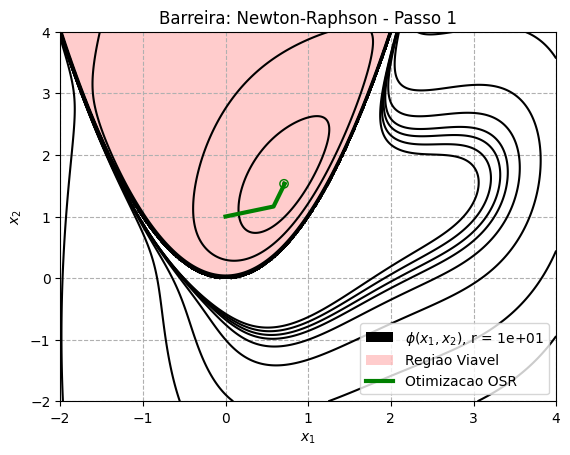

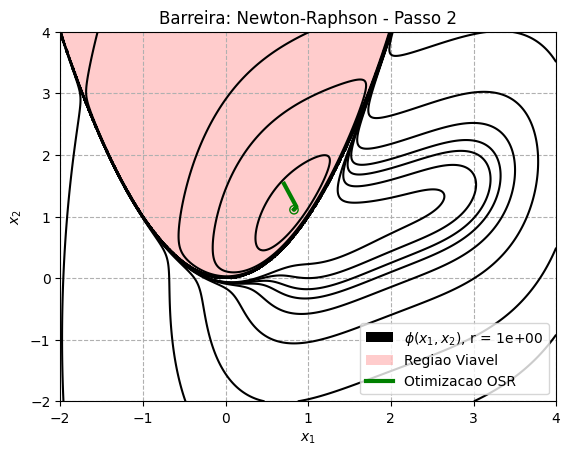

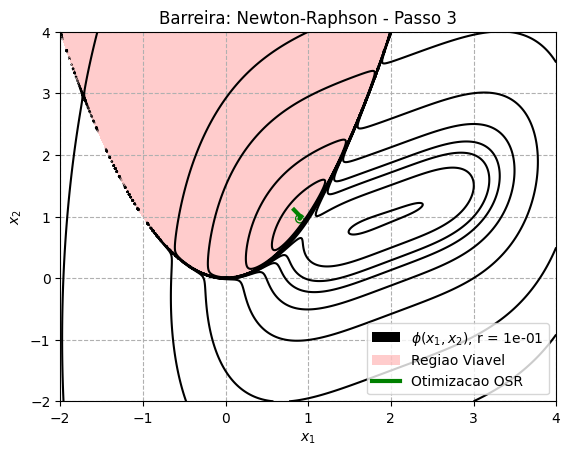

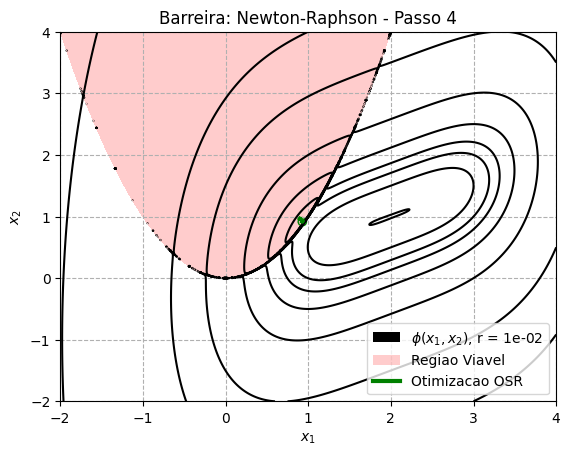

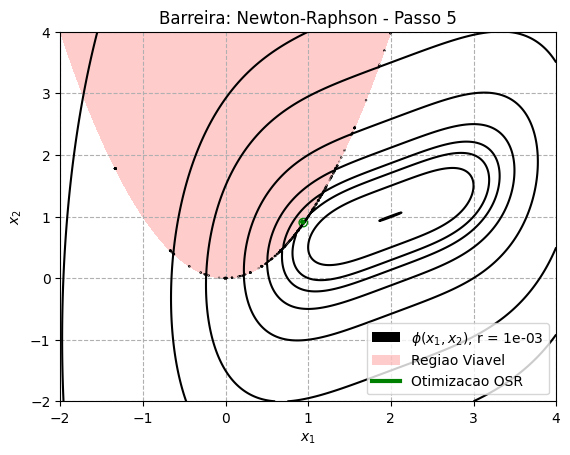

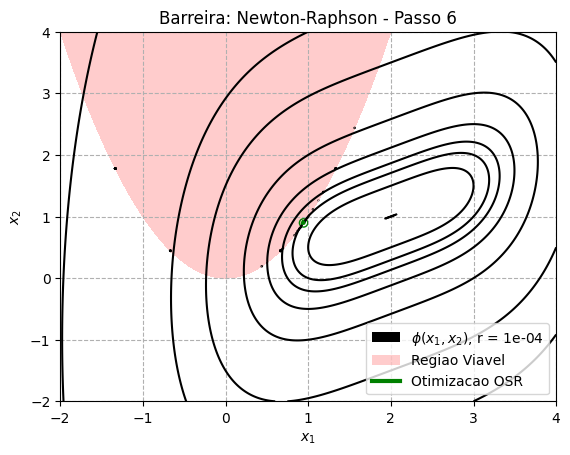

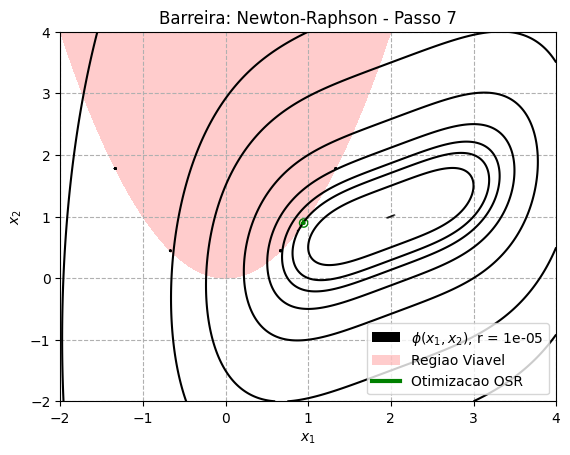

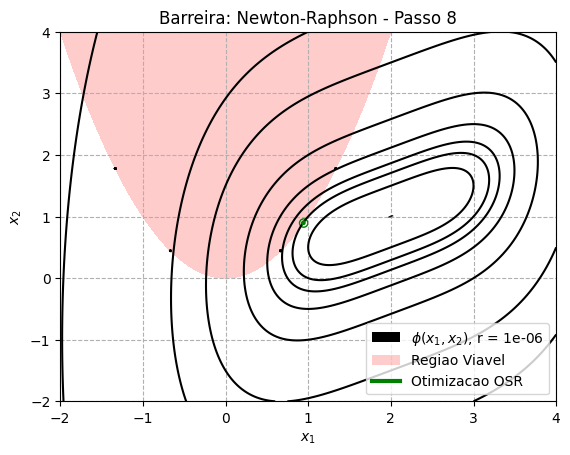

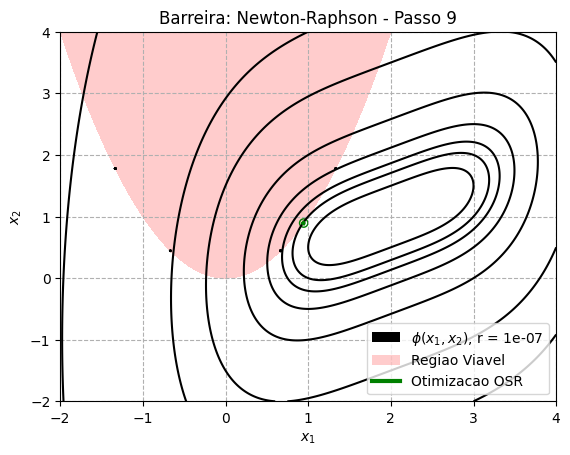

In [431]:
x1 = np.linspace(-2,4, 1000)
x2 = np.linspace(-2,4, 1000)
X1, X2 = np.meshgrid(x1, x2)

levellist = [0, 1 , 2, 3, 5, 10, 25, 50, 250, 500, 1000,]
k = 0
for item in listResultsOSR :
    
    fig, ax = plt.subplots()
    # print(ocr.phi_bar(item[0][-1], item[1], item[2]))
    if metodo_ocr == 1:
        X3 = ocr.phi_penal([X1,X2], item[1], item[2])
        
    elif metodo_ocr == 2:
        X3 = ocr.phi_bar([X1, X2], item[1], item[2])
       
    niveis = ax.contour(X1, X2, X3, levellist, colors='black')
    #ax.clabel(niveis, inline=1, fontsize=8)
      
    X3 = cl1([X1,X2])
    plt.contourf(X1, X2, X3, [-100,0], colors='r', alpha=0.2)
          
    x = []
    y = []
    for P in item[0]:
        x.append(P[0])
        y.append(P[1])
    line3, = ax.plot(x, y, color='g', linewidth='3')
    ax.scatter(item[0][-1][0], item[0][-1][1], color='green',marker='o', facecolors='none')
    ax.set_xlabel('$x_1$', fontsize='10')
    ax.set_ylabel('$x_2$', fontsize='10')   
    
    proxy = [plt.Rectangle((0,0),1,1,fc = 'black'), plt.Rectangle((0,0),1,1,fc = 'red', alpha=0.2), line3]    
    ax.legend(proxy, [f'$\phi(x_1,x_2)$, r = {item[2]:.0e}', 'Regiao Viavel', 'Otimizacao OSR'], loc='lower right')
    
    ax.grid(linestyle='--')
    titulo = n_met_ocr + ': ' + n_met + ' - ' + 'Passo ' + str(k+1)
    ax.set_title(titulo, fontsize=12)
    k = k+1          

# titulo = n_met_ocr + ' - ' + n_met + ': ' + np.array2string(listP_OCR[0], precision = 2, separator=' ') + ' => ' + np.array2string(listP_OCR[-1], precision = 2, separator=' ')
# fig.suptitle(titulo, fontsize=14)
# fig.tight_layout()
# plt.figure(figsize=(10,20))
plt.show()


### Plot de $f(x_1, x_2)$ e restrições

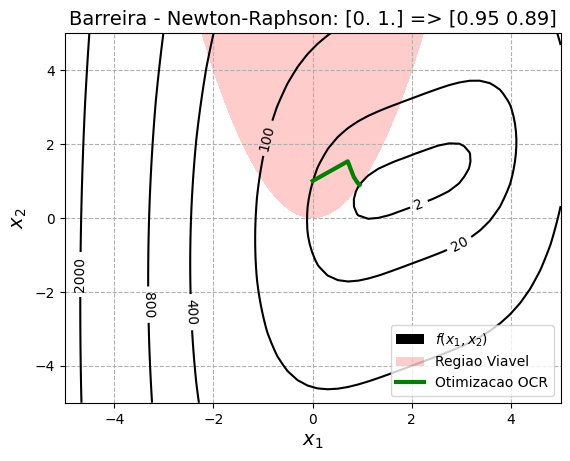

In [432]:
x1 = np.linspace(-5,5)
x2 = np.linspace(-5,5)
X1, X2 = np.meshgrid(x1, x2)

X3 = f([X1, X2])
    
figura, ax = plt.subplots()
        
niveis = ax.contour(X1, X2, X3, [0,2,20,100,400,800,2000,4000], colors='black')
ax.clabel(niveis, inline=1, fontsize=10)

# for hk in hk_list:
#     X3 = hk([X1,X2])
#     plt.contour(X1, X2, X3, [0], colors='red')
    
# for cl in cl_list:
#     X3 = cl([X1,X2])
#     plt.contour(X1, X2, X3, [0], colors='blue')

X3 = cl([X1,X2])
plt.contourf(X1, X2, X3, [-10, 0], colors='red', alpha=0.2)
    
x = []
y = []
for P in listP_OCR:
    x.append(P[0])
    y.append(P[1])

line3, = ax.plot(x, y, color='g', linewidth='3')

proxy = [plt.Rectangle((0,0),1,1,fc = 'black'), plt.Rectangle((0,0),1,1,fc = 'red', alpha=0.2), line3]    
ax.legend(proxy, [f'$f(x_1,x_2)$', 'Regiao Viavel', 'Otimizacao OCR'], loc='lower right')

ax.set_xlabel('$x_1$', fontsize='14')
ax.set_ylabel('$x_2$', fontsize='14')
ax.grid(linestyle='--')
titulo = n_met_ocr + ' - ' + n_met + ': ' + np.array2string(listP_OCR[0], precision = 2, separator=' ') + ' => ' + np.array2string(listP_OCR[-1], precision = 2, separator=' ') 
ax.set_title(titulo, fontsize='14')
plt.show()